 LangGraph, LangChain, MCP(Multi-server Command Protocol), 그리고 Neo4j 및 벡터DB 리트리버를 연동한 멀티 툴 기반 챗봇 시스템의 초기 구성 code

In [1]:
! pip install langchain-mcp-adapters

  Using cached langchain_core-0.3.66-py3-none-any.whl.metadata (5.8 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached PyYAML-6.0.2-cp313-cp313-win_amd64.whl.metadata (2.1 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached orjson-3.10.18-cp313-cp313-win_amd64.whl.metadata (43 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached zstandard-0.23.0-cp313-cp313-win_amd64.whl.metadata (3.0 kB)
  Using cached anyio-4.9.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached certifi-2025.6.15-py3-none-any.whl.metadata (2.4 kB)
  Using cached httpcore-1.0.9-py3-n

In [3]:
! pip install langgraph

  Using cached langgraph_checkpoint-2.1.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached ormsgpack-1.10.0-cp313-cp313-win_amd64.whl.metadata (44 kB)
Using cached langgraph_checkpoint-2.1.0-py3-none-any.whl (43 kB)
Using cached ormsgpack-1.10.0-cp313-cp313-win_amd64.whl (121 kB)
Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl (30 kB)

   ------ --------------------------------- 1/6 [ormsgpack]
   ------------- -------------------------- 2/6 [langgraph-sdk]
   ------------- -------------------------- 2/6 [langgraph-sdk]
   ------------- -------------------------- 2/6 [langgraph-sdk]
   -------------------- ------------------- 3/6 [langgraph-checkpoint]
   -------------------- ------------------- 3/6 [langgraph-checkpoint]
   -------------------- ------------------- 3/6 [langgraph-checkpoint]
   -------------------- ------------------- 3/6 [langgraph-checkpoint]
   -------------------------- ------------- 4/6 [l

In [5]:
! pip install mcp langchain-mcp-adapters


In [6]:
import subprocess
import sys

# 설치할 패키지 리스트
packages = [
    "langchain",
    "langchain-openai",
    "langchain-community",
    "langgraph",
    "langgraph[cli]",
    "python-dotenv",
    "openai",
    "tqdm"
]

# pip install 실행
subprocess.check_call([sys.executable, "-m", "pip", "install", *packages])

0

In [7]:
import sys
sys.path.append('jiyeon/mcp')  # 또는 'Wang_Gyu/code/mcp' 등 실제 경로

from typing import Annotated, List, TypedDict
from langgraph.graph.message import add_messages
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
#from mcp import ClientSession, StdioServerParameters
from langchain_mcp_adapters.client import MultiServerMCPClient
from openai import OpenAI


load_dotenv()

#OpenAI API 키를 기반으로 클라이언트 생성
model_client = OpenAI()

#챗봇 상태정의
#LangGraph에서 사용될 상태 객체
#챗봇 흐름 중 주고받는 데이터 구조 정의
class ChatbotState(TypedDict):
    question: Annotated[str, "Question"]   #사용자 질문
    tools: Annotated[List, "Tools"] #사용할 도구
    neo4j_documents: Annotated[List, "Neo4j_Documents"] #	Neo4j 리트리버가 가져온 결과 
    vector_documents : Annotated[List,"Vector_Documents"] #VectorDB 리트리버가 가져온 결과
    final_answer: Annotated[str, "Final_Answer"] #최종응답
    messages: Annotated[List, add_messages] #전체 대화 메시지 기록록

#메모리 저장소 정의 
memory = MemorySaver()

#MCP 클라이언트 설정 
#두 개의 리트리버 서버(NEO4J와 VECTORDB)를 subprocess로 실행해서 연결
#MCP는 멀티툴을 병렬로 관리할 수 있게 해주는 프로토콜 
client = MultiServerMCPClient(
    {
        "neo4j_retriever": {
            "command": "/opt/anaconda3/envs/boaz/bin/python",
            "args": ["mcp_neo4j_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/opt/anaconda3/envs/boaz/bin/python",
            "args": ["mcp_vectordb_server.py"],
            "transport": "stdio",
        },
    }
)

#MCP에서 사용할 도구 정보 받아오기 
#위에서 연결한 MCP서버들이 제공하는 툴 목록을 비동기로 받아옴
tools = await client.get_tools()

#도구 이름 -> 객체 매핑 
#툴 이름을 키로 하는 딕셔너리로 만들어 쉽게 접근할 수 있게 함 
tools_dict = {tool.name: tool for tool in tools}

print(tools_dict)

UnsupportedOperation: fileno

In [ ]:
import sys
sys.path.append('jiyeon/mcp')  # 또는 'Wang_Gyu/code/mcp' 등 실제 경로

from typing import Annotated, List, TypedDict
from langgraph.graph.message import add_messages
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
#from mcp import ClientSession, StdioServerParameters
from langchain_mcp_adapters.client import MultiServerMCPClient
from openai import OpenAI


load_dotenv()

#OpenAI API 키를 기반으로 클라이언트 생성
model_client = OpenAI()

#챗봇 상태정의
#LangGraph에서 사용될 상태 객체
#챗봇 흐름 중 주고받는 데이터 구조 정의
class ChatbotState(TypedDict):
    question: Annotated[str, "Question"]   #사용자 질문
    tools: Annotated[List, "Tools"] #사용할 도구
    neo4j_documents: Annotated[List, "Neo4j_Documents"] #	Neo4j 리트리버가 가져온 결과 
    vector_documents : Annotated[List,"Vector_Documents"] #VectorDB 리트리버가 가져온 결과
    final_answer: Annotated[str, "Final_Answer"] #최종응답
    messages: Annotated[List, add_messages] #전체 대화 메시지 기록록

#메모리 저장소 정의 
memory = MemorySaver()

#MCP 클라이언트 설정 
#두 개의 리트리버 서버(NEO4J와 VECTORDB)를 subprocess로 실행해서 연결
#MCP는 멀티툴을 병렬로 관리할 수 있게 해주는 프로토콜 
client = MultiServerMCPClient(
    {
        "neo4j_retriever": {
            "command": "/opt/anaconda3/envs/boaz/bin/python",
            "args": ["mcp_neo4j_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/opt/anaconda3/envs/boaz/bin/python",
            "args": ["mcp_vectordb_server.py"],
            "transport": "stdio",
        },
    }
)

#MCP에서 사용할 도구 정보 받아오기 
#위에서 연결한 MCP서버들이 제공하는 툴 목록을 비동기로 받아옴
tools = await client.get_tools()

#도구 이름 -> 객체 매핑 
#툴 이름을 키로 하는 딕셔너리로 만들어 쉽게 접근할 수 있게 함 
tools_dict = {tool.name: tool for tool in tools}

print(tools_dict)

UnsupportedOperation: fileno

 Function Calling (Tool Use) 기능을 위해 GPT에게 "너는 이런 도구들을 사용할 수 있어"라고 알려주는 명세

 - 도구 이름을 선택하고, 파라미터를 채우고
 - 툴을 호출한 후, 툴의 응답을 받아 다음 단계로 넘긴다

In [92]:
#도구 하나에 대한 정의 

tools = [
    {
        "type": "function", #GPT가 이걸 함수처럼 호출할 수 있음
        "name": "neo4j_retriever", #함수의 이름 (GPT가 호출 시 사용)
        #도구의 용도- 구조화된 환자 기록(Neo4j같은 그래프 db기반반)
        "description": "Query structured patient-related data, such as surgeries, lab results, or graph-based records.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query about the patient's clinical records"
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    },
    {
        "type": "function",
        "name": "VectorDB_retriever",
        "description": "Retrieve general medical knowledge (diseases, treatments, guidelines).",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query about medical knowledge"
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    }
]

In [ ]:
tools = [
    {
        "type": "function", #GPT가 이걸 함수처럼 호출할 수 있음
        "name": "neo4j_retriever", #함수의 이름 (GPT가 호출 시 사용)
        #도구의 용도- 구조화된 환자 기록(Neo4j같은 그래프 db기반반)
        "description": 
            """
            Use this tool when the user's query is explicitly about patient-specific 
            clinical information or refers to structured medical records.

            This includes queries containing terms such as: 
            '환자', '환자정보', '환자기록', '환자이력', '환자데이터', '환자상태', 
            '수술이력', '검사기록', '진료기록', '입원', '퇴원', '복용약물',
            '진단', '수술명', '마취제', '마취제 유형', '수술 전 상태', '수술 후 상태'.

            These queries typically require retrieving structured data from graph-based 
            medical records (e.g., Neo4j) related to an individual patient or to specific 
            clinical procedures.

            This tool is designed to access and return relevant information such as:
            surgery history, diagnoses, anesthesia types used, pre- and post-operative conditions, 
            medication usage, lab results, and hospitalization records.

            Use this tool when the question involves:
            - Specific patients
            - Specific treatments or surgeries
            - Named diagnoses or procedures
            - Clinical state before/after operations

            Do not use this tool for general medical knowledge, non-clinical topics, or 
            queries unrelated to structured or relational patient data.
            """,
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": 
                    '''
                    Please write the query as a natural language question about the patient's clinical records.

                    The query will be interpreted to explore nodes (e.g., Surgery, Anesthesia, Diagnosis, Patient) and their relationships (e.g., surgeries received by a specific patient) in a graph database.

                    For example, the question "Tell me the name of the most recent surgery and the anesthesia used" will be processed as a query exploring connections between Surgery and Anesthesia nodes.

                    Also, the question "Tell me the pre-operative condition and diagnosis of patient Hong Gil-dong" will be interpreted as a query that finds the Person node with the name 'Hong Gil-dong' and extracts the related Pre-op condition and Diagnosis nodes.

                    If a patient name is specified, please write the query to retrieve not only that patient but also other patients with similar symptoms.

                    If no patient name is given, please write the query to search for patients matching the symptoms, surgery names, or diagnoses mentioned in the question.

                    The more specific the patient information or clinical conditions included, the more accurately the relevant data can be retrieved.

                    '''
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    },
    {
        "type": "function",
        "name": "VectorDB_retriever",
                "description": '''Use this tool when the user's query involves general clinical or medical knowledge that is not tied to a specific patient.

                This includes queries containing medical or procedural terms such as:
                surgery names (e.g., "cholecystectomy", "cardiac surgery"), anesthesia types (e.g., "general anesthesia", "local anesthesia"), medications, clinical processes, or treatment guidelines.

                Example queries:
                - "How does general anesthesia work?"
                - "What are common complications of this surgery?"
                - "What anesthetics are typically used in pediatric patients?"

                These types of queries are interpreted as requests for background medical knowledge or conceptual explanations. The tool retrieves semantically relevant information from a vector-based medical knowledge database.

                Do not use this tool for patient-specific record queries or when structured relational data is needed, such as diagnosis timelines or surgical histories.'''
                ,
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": '''Construct a query that focuses on general medical or clinical knowledge, excluding any patient-specific details.

                The query should be based on concepts extracted from the user's original question, such as surgery names, anesthesia types, diagnoses, medications, or treatment processes.

                For example, if the user asks "What kind of anesthesia was used for Kim's surgery?", the query should be reformulated as "What types of anesthesia are commonly used for that kind of surgery?"

                Avoid including patient names, identifiers, or individual medical histories. Focus on retrieving background information or typical medical explanations that are generally applicable.'''
                                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    }
]

In [93]:
#프롬프트 입력. 
LLM_SYSTEM_PROMPTY = """
# INSTRUCTION
당신은 의료 데이터에 특화된 전문가 AI입니다.
사용자의 질문에 대해 다음 두 가지 출처의 정보를 참고하여 답변을 생성하세요:

1. 🔎 Neo4j 검색 결과: 구조화된 환자 관련 정보 (예: 수술 이력, 검사 기록 등)
2. 📚 VectorDB 검색 결과: 일반적인 의학 지식 (예: 증상 설명, 치료 가이드라인 등)

- 두 결과 모두 존재할 경우, 각 출처를 구분하여 통합적으로 반영하되, 중복 내용은 요약하거나 통합하세요.
- 한 쪽의 결과만 존재할 경우, 해당 결과만을 바탕으로 답변하되, 정보의 한계에 대해 언급하지 말고 최대한 성실히 답변하세요.
- 결과가 너무 적거나 애매하더라도 반드시 유의미한 설명을 제공하려고 노력하세요.
- 불필요한 서론 없이, 질문에 바로 답변하세요.

# Neo4j CONTEXT
{Neo4j}

# Vector DB CONTEXT
{VectorDB}

# Question
{question}
"""

model = ChatOpenAI(temperature=0.2,
                      model_name="gpt-4o")

LLM이 도구를 이용해 정보를 수집하고, 최종 답변을 생성하기 위한 일련의 단계를 나눠서 처리

1. decision_tools: 어떤 도구(VectorDB, Neo4j)를 사용할지 결정
2. vector_db: VectorDB 리트리버 호출 (선택된 경우)
3. neo4j_db: Neo4j 리트리버 호출 (선택된 경우)
4. merge_outputs: 각 결과를 바탕으로 GPT가 답변 생성

In [94]:
async def decision_tools(state: ChatbotState):
    
    question = state["question"]

    input_messages = [
        {"role": "system", "content": "Decide which tools to use to answer the user's question. You may call one or both."},
        {"role": "user", "content": question}
    ]
    
    response = model_client.responses.create(model="gpt-4.1",
                                             input=input_messages,
                                             tools=tools)

    selected_tools = [tool.name for tool in response.output]

    return ChatbotState(tools=selected_tools)

async def vector_db(state: ChatbotState):
    question = state["question"]
    
    if "VectorDB_retriever" in state["tools"]:
        vectordb_tool = tools_dict["VectorDB_retriever"]
        
        if vectordb_tool:
            result = await vectordb_tool.ainvoke({"query": question})
        else:
            result = "VectorDB 도구를 찾을 수 없습니다."
    else:
        result = None

    return ChatbotState(vector_documents=result)

async def neo4j_db(state: ChatbotState):
    question = state["question"]
    
    if "neo4j_retriever" in state["tools"]:
        neo4j_tool = tools_dict.get("neo4j_retriever")
        if neo4j_tool:
            result = await neo4j_tool.ainvoke({"query": question})
        else:
            result = "Neo4j 도구를 찾을 수 없습니다."
    else:
        result = None

    return ChatbotState(neo4j_documents=result)

async def merge_outputs(state:ChatbotState):

    question = state['question']
    vector_documents = state['vector_documents']
    neo4j_documents = state['neo4j_documents']

    formatted = LLM_SYSTEM_PROMPTY.format(Neo4j = neo4j_documents,
                                          VectorDB = vector_documents,
                                          question = question)
    response = model.invoke(formatted)
    response_text = response.content if isinstance(response, AIMessage) else str(response)

    return ChatbotState(final_answer=response_text,
                        messages=[("user", question), ("assistant", response_text)])

LLM 워크플로우를 상태 기반 그래프(State Machine) 구조로 모델링할 수 있게 해주는 프레임워크

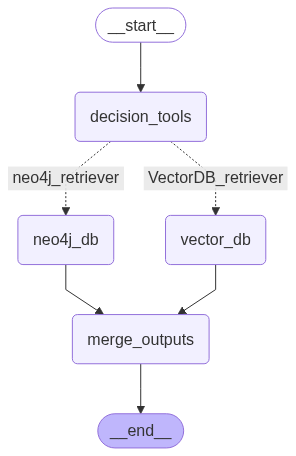

In [95]:
builder = StateGraph(ChatbotState)

builder.add_node("decision_tools", decision_tools)
builder.add_node("vector_db", vector_db)
builder.add_node("neo4j_db", neo4j_db)
builder.add_node("merge_outputs", merge_outputs)

# 그래프 시작점 -> 첫 노드 연결 
builder.add_edge(START, "decision_tools")

#조건 분기: 어떤 도구를 선택했는지에 따라 다음 노드 결정
def route_tools(state: ChatbotState):
    return state["tools"]

builder.add_conditional_edges(
    "decision_tools",
    route_tools,
    {
        "neo4j_retriever": "neo4j_db",
        "VectorDB_retriever": "vector_db"
    }
)
#리트리버 실행 후 → merge_outputs 로 이어짐
builder.add_edge("neo4j_db", "merge_outputs")
builder.add_edge("vector_db", "merge_outputs")
builder.add_edge("merge_outputs", END)

builder.compile(checkpointer=memory)

어떤 질문(Question) 을 넣고, LangChain graph를 실행해서, 질문에 대한 응답을 생성하는 작업을 수행

In [96]:
from langchain_core.runnables import RunnableConfig
#실행 환경에 대한 설정을 담는 객체
config = RunnableConfig(configurable={"thread_id": 1})

question = "Kasabach-Merrritt Syndrome이 뭐야?"

#runnable graph를 실제로 실행 가능한 형태로 컴파일
#상태 저장 방식. 
graph = builder.compile(checkpointer=memory)

initial_state = {
    "question": question,
    "tools": [],
    "neo4j_documents": [],
    "vector_documents": [],
    "final_answer": "",
    "messages": [],
}

events = []
async for event in graph.astream(initial_state, config=config):
    print(event)


{'decision_tools': {'tools': ['VectorDB_retriever']}}
{'vector_db': {'vector_documents': 'Kasabach-Merritt syndrome은 거대혈관종, 혈소판감소증, 출혈경향을 동반하는 희귀 질환이다. 혈소판감소증의 주된 원인은 혈관종 내에서 혈소판의 비정상적 소모와 파괴로 생각되고 있으며, 마취와 수술 중 심각한 응고장애로 인한 대량출혈이 발생할 수 있다. 우측 하지 혈관종을 가진 환아는 다양한 내과적 치료에도 반응하지 않는 현저한 혈소판감소증, 파종혈관내응고, 패혈증 소견을 보였고, 좌측 전두엽 국소출혈로 인한 발작까지 발생하여 출혈성 경향을 교정하지 못한 상태에서 무릎밑절단술을 시행하였다\n.].\nKasabach-Merritt syndrome은 거대혈관종, 혈소판감소증, 출혈경향을 동반하고 6개월 이하의 영아에서 주로 발생하는 드문 질환이다. 혈소판감소증의 주된 원인은 혈관종 내에서 혈소판의 비정상적 소모와 파괴로 생각되고 있다. Gilon 등은 말초혈액보다 혈관종 내의 혈액에 혈소판이 더 많다는 것을 발견했고, Hoak 등은 혈관종 안에서 혈전이 형성된다는 것을 확인하였으며, Silver 등은 혈관종 내부의 다발성 모세혈관장애를 치유하기 위해 혈소판이 사용된다고 보고하였다\n. Kasabach-Merritt syndrome은 마취와 수술 중 위험한 상황이 발생할 수 있지만, 국내에서는 이에 대한 보고가 없었다. 저자들은 반복적인 혈소판 수혈에도 혈소판이 현저히 감소된 환아에서 대량출혈을 동반하는 무릎밑절단술의 마취를 경험하였기에 문헌 고찰과 함께 보고하는 바이다. \n체태연령 37주 출생체중 3,100 gm, 질식분만으로 출생한 환자는 출생 당시부터 우측 하지에 부기(swelling) 소견을 보였고 집에서 경과 관찰 중이었다\n. 수술 전 심박수 130회/분, 혈압 85/50 mmHg였고, 활력징후가 수술 중 잘 유지되었기 때문에 승압제는 사용하지 않았다. 수술 후에는 기도출혈, 심